In [2]:
!pip install pandas numpy scikit-learn plotly spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 7.0 MB/s eta 0:00:00


Explained Variance Ratio: [0.4826145  0.22448305 0.10429116]


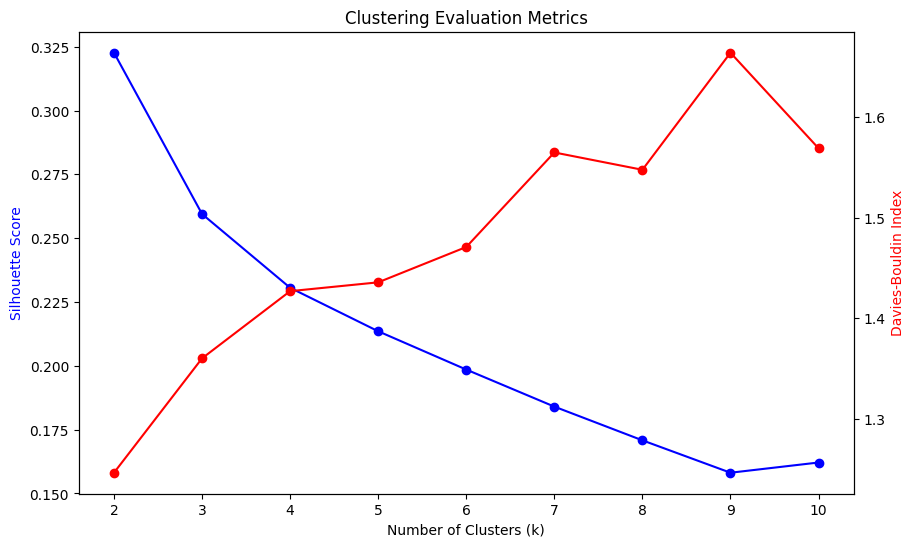

Optimal number of clusters (k): 5



Top Recommendations:
1. Storm And Thunder by Earth & Fire
   Album: Song Of The Marching Children
   Preview: None
   Spotify Link: https://open.spotify.com/track/6Jwddt9NSEujC29SAd6kIA

2. Fix You by Coldplay
   Album: X&Y
   Preview: None
   Spotify Link: https://open.spotify.com/track/7LVHVU3tWfcxj5aiPFEW4Q

3. Music - Remastered 1985 by John Miles
   Album: Rebel (Remastered 1985)
   Preview: None
   Spotify Link: https://open.spotify.com/track/49mrwztG66NtbDe0adJ2Yx

4. The Blower's Daughter by Damien Rice
   Album: O
   Preview: None
   Spotify Link: https://open.spotify.com/track/4B2lJinAkeNLSJjcq3dg8Q

5. Words by Bee Gees
   Album: Horizontal (Deluxe Version)
   Preview: None
   Spotify Link: https://open.spotify.com/track/07PIhdmyYIw8dMeDMsx9FU

6. The End by The Doors
   Album: The Doors
   Preview: None
   Spotify Link: https://open.spotify.com/track/5UgT7w6zVZjP3oyawMzbiK

7. All I Want by Kodaline
   Album: In A Perfect World (Expanded Edition)
   Preview: None
   Spotif

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import plotly.express as px
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


SPOTIFY_CLIENT_ID = '22277cd3c49d4863bb3dc53d6b8f119d'
SPOTIFY_CLIENT_SECRET = 'cbacf835e5424d7c94bda814792cddcb'

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET))


data = pd.read_csv("/content/Spotify-2000.csv")


features = ["Beats Per Minute (BPM)", "Energy", "Danceability", "Loudness (dB)", "Valence", "Acousticness", "Speechiness"]
data_features = data[features]


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_features)


pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, labels)
    db_score = davies_bouldin_score(data_scaled, labels)
    ch_score = calinski_harabasz_score(data_scaled, labels)
    scores.append((k, silhouette_avg, db_score, ch_score))


scores_df = pd.DataFrame(scores, columns=["k", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(scores_df["k"], scores_df["Silhouette"], marker="o", label="Silhouette", color="blue")
ax1.set_ylabel("Silhouette Score", color="blue")
ax1.set_xlabel("Number of Clusters (k)")
ax2.plot(scores_df["k"], scores_df["Davies-Bouldin"], marker="o", label="Davies-Bouldin", color="red")
ax2.set_ylabel("Davies-Bouldin Index", color="red")
plt.title("Clustering Evaluation Metrics")
plt.show()


optimal_k = 5
print(f"Optimal number of clusters (k): {optimal_k}")


kmeans = KMeans(n_clusters=int(optimal_k), random_state=42)
data["Cluster"] = kmeans.fit_predict(data_scaled)


data_pca_df = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3"])
data_pca_df["Cluster"] = data["Cluster"]
data_pca_df["Title"] = data["Title"]
fig = px.scatter_3d(
    data_pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Cluster",
    hover_name="Title",
    title="3D Visualization of Clusters",
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig.show()


def search_song_on_spotify(title, artist=None):
    try:
        query = f"{title} {artist}" if artist else title
        results = sp.search(q=query, type='track', limit=1)
        if results['tracks']['items']:
            track = results['tracks']['items'][0]
            return {
                "Track Name": track['name'],
                "Artist": track['artists'][0]['name'],
                "Album": track['album']['name'],
                "Preview URL": track['preview_url'],
                "Spotify Link": track['external_urls']['spotify']
            }
    except Exception as e:
        print(f"Error fetching song from Spotify: {e}")
    return None


def recommend_music(user_input, top_n=5, dynamic_features=None):

    user_input_df = pd.DataFrame([user_input], columns=features)


    user_input_scaled = scaler.transform(user_input_df)


    cluster_label = kmeans.predict(user_input_scaled)[0]


    recommendations = data[data["Cluster"] == cluster_label].copy()
    recommendations["Similarity"] = np.linalg.norm(
        scaler.transform(recommendations[features]) - user_input_scaled, axis=1
    )


    if dynamic_features:
        total_weight = sum(dynamic_features.values())
        normalized_weights = {k: v / total_weight for k, v in dynamic_features.items()}
        for feature, weight in normalized_weights.items():
            if feature in features:
                recommendations["Similarity"] *= weight


    top_recommendations = recommendations.nsmallest(top_n, "Similarity")[
        ["Title", "Artist", "Beats Per Minute (BPM)", "Energy", "Danceability", "Valence", "Similarity"]
    ]


    enhanced_recommendations = []
    for _, row in top_recommendations.iterrows():
        song_details = search_song_on_spotify(row["Title"], row["Artist"])
        if song_details:
            enhanced_recommendations.append({**row.to_dict(), **song_details})

    return pd.DataFrame(enhanced_recommendations)


user_input = [120, 0.8, 0.7, -5, 0.9, 0.2, 0.1]
dynamic_weights = {"Energy": 1.5, "Valence": 0.8}
recommended_songs = recommend_music(user_input, top_n=10, dynamic_features=dynamic_weights)

if not recommended_songs.empty:
    print("\nTop Recommendations:")
    for idx, song in recommended_songs.iterrows():
        print(f"{idx + 1}. {song['Track Name']} by {song['Artist']}")
        print(f"   Album: {song['Album']}")
        print(f"   Preview: {song['Preview URL']}")
        print(f"   Spotify Link: {song['Spotify Link']}\n")
else:
    print("No recommendations found based on the input.")